In [1]:
from ppget.source import ModelSource

start_date = "2008-01-01"
end_date = "2008-07-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [2]:
import pandas as pd

series = source.series()
kw_hour = pd.DataFrame(zip(list(series.values),list(series.index.hour)), index=series.index)
kw_hour.head()

,0,1
timestamp,,
2008-01-01 00:00:00,1.5828,0
2008-01-01 00:10:00,1.5366,0
2008-01-01 00:20:00,1.5768,0
2008-01-01 00:30:00,1.6774,0
2008-01-01 00:40:00,1.6438,0


In [3]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 32
MODEL_NAME = "model/cnn1D_multi/"

builder = DatasetBuilder(kw_hour, data_split=TrainSplit(train=0.8, validation=0.1), window_size=WINDOW, all_features=True, normalised=False)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["validation"]["X"].shape, S["validation"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((20940, 32, 2), (20940,), (2617, 32, 2), (2617,), (2619, 32, 2), (2619,))

In [4]:
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.losses import MeanSquaredError
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, InputLayer, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.python.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(InputLayer((WINDOW, 2)))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Conv1D(32, kernel_size=2, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, 'relu'))
model.add(Dense(32, 'relu'))
model.add(Dense(1, 'linear'))
checkpoint = ModelCheckpoint(MODEL_NAME, save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 31, 64)            320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            4128      
_________________________________________________________________
dropout (Dropout)            (None, 30, 32)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               123136    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8

2022-06-02 17:41:06.752103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
%%time
history = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=100,
                    validation_data=(S["validation"]["X"], S["validation"]["y"]),
                    verbose=2,
                    callbacks=[checkpoint])

Epoch 1/100
655/655 - 3s - loss: 0.8321 - root_mean_squared_error: 0.9122 - val_loss: 0.5034 - val_root_mean_squared_error: 0.7095
INFO:tensorflow:Assets written to: model/cnn1D_multi/assets
Epoch 2/100
655/655 - 2s - loss: 0.5105 - root_mean_squared_error: 0.7145 - val_loss: 0.4735 - val_root_mean_squared_error: 0.6881
INFO:tensorflow:Assets written to: model/cnn1D_multi/assets
Epoch 3/100
655/655 - 2s - loss: 0.4559 - root_mean_squared_error: 0.6752 - val_loss: 0.4275 - val_root_mean_squared_error: 0.6539
INFO:tensorflow:Assets written to: model/cnn1D_multi/assets
Epoch 4/100
655/655 - 2s - loss: 0.4201 - root_mean_squared_error: 0.6482 - val_loss: 0.3880 - val_root_mean_squared_error: 0.6229
INFO:tensorflow:Assets written to: model/cnn1D_multi/assets
Epoch 5/100
655/655 - 2s - loss: 0.3908 - root_mean_squared_error: 0.6252 - val_loss: 0.3916 - val_root_mean_squared_error: 0.6257
Epoch 6/100
655/655 - 2s - loss: 0.3729 - root_mean_squared_error: 0.6107 - val_loss: 0.3445 - val_root_m

In [6]:
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

2619

In [8]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results

,Predictions,Ground Truth
0,0.516880,1.1414
1,1.435090,0.9908
2,1.294576,0.7830
3,1.092473,0.7820
4,1.027839,1.5792
...,...,...
2614,0.405003,0.4766
2615,0.534144,1.6256
2616,1.699726,1.3018
2617,1.415021,1.2568


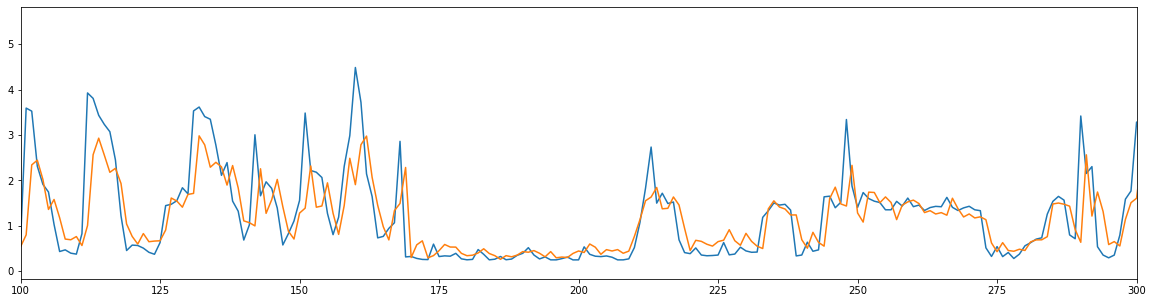

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mplt
mplt.rcParams["figure.figsize"] = (20,5)

plt.xlim([100, 300])
plt.plot(test_results["Ground Truth"])
plt.plot(test_results["Predictions"])
plt.show()